## Configuration

### Imports

In [1]:
# Utilities
from IPython.display import display
import os
import numpy as np
import time
import pandas as pd

# MongoDB functionality
from pymongo import MongoClient, InsertOne, UpdateOne
from bson import ObjectId
from collections.abc import MutableMapping

# Graphics
import matplotlib.pyplot as plt
from matplotlib.pyplot import text
import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style("whitegrid")
sns.set_style({'font.family':'monospace'})
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from wordcloud import WordCloud
from PIL import Image

# Network analysis
import networkx as nx

ROOT_DIR = "/home/mattia/javier/botbusters-spanish-general-elections-network-analysis/"

# Change path to root
os.chdir(ROOT_DIR)

# MongoDB parameters
mongoclient = MongoClient('localhost', 27017)
db = mongoclient.influence

### Support Functions

In [2]:
def flatten(d, parent_key='', sep='_'):
    """Formats MongoDB results
    
    Keyword arguments:
    d -- dictionary with key and uncleaned values
    parent_key --
    sep --
    """
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

def make_objid(text):
    """Makes an ObjectId of 4 bytes
    
    Keyword arguments:
    text -- string to be converted into Object ID
    """
    text = str(text)
    if not text.strip():
        return None
    try:
        return ObjectId(text.rjust(24,"0"))
    except Exception as ex:
        print(text, ex)
        return None

def get_tweets(collection):
    """
    Gets tweets
    
    collection - Tweets MongoDB collection
    """
    tweets = list(collection
                    .find({'sampled':True},{'_id': True, 'tweet_id': True, 'user_id' : True, 'date':True})
                   )
    
    print("Number of tweets:", len(tweets))
    tweets = [flatten(t) for t in tweets]
    df_tweets = pd.DataFrame(tweets)
    df_tweets.user_id = df_tweets.user_id.apply(lambda t : str(t))
    df_tweets.user_id = df_tweets.user_id.astype(str)
    df_tweets.rename(columns={'user_id':'tweet_author'},inplace=True)
    return df_tweets
    
def get_retweets(collection):
    """
    Gets retweets
    
    collection - Retweets MongoDB collection
    """
    retweets = list(collection
                    .find({'sampled':True},{'_id': False, 'tweet_id': True, 'user_id' : True, 'date':True})
                   )
    
    print("Number of retweets:", len(retweets))
    retweets = [flatten(r) for r in retweets]
    df_retweets = pd.DataFrame(retweets)
    df_retweets.user_id = df_retweets.user_id.apply(lambda t : str(t))
    df_retweets.user_id = df_retweets.user_id.astype(str)
    df_retweets.date = df_retweets.date.astype("datetime64")
    df_retweets.rename(columns={'user_id':'retweet_author'},inplace=True)
    return df_retweets

def get_users(collection):
    """
    Gets users
    
    collection - Users MongoDB collection
    """
    users = list(collection.find({ '$and' : [ { 'sampled': True } , { 'botscore' : { '$gte' : 0 } }]},
                                 {'_id' : True, 'botscore' : True})
                )
    print("Number of sampled users with botscore in DB:", len(users))
    users = [flatten(u) for u in users]
    df_users = pd.DataFrame(users)
    df_users._id = df_users._id.apply(lambda t : str(t))
    df_users._id = df_users._id.astype(str)
    return df_users


def get_hashtags(collection):
    """
    Gets hashtags
    
    collection - Hashtags MongoDB collection
    """
    hashtags = list(collection.find({},
                                 {'_id' : False, 'tweet_id' : True, 'hashtag' : True})
                )
    print("Number of hashtags in DB:", len(hashtags))
    df_hashtags = pd.DataFrame(hashtags)
    return df_hashtags

## Data preparation

#### Getting users from DB...

In [3]:
users = get_users(db.users)
display(users.head(5))

Number of sampled users with botscore in DB: 1150709


,_id,botscore
0,000000000000002266588688,0.16
1,000000000000000471028961,0.03
2,000000000000002792368467,0.11
3,000000000000004068857357,0.01
4,000000000000000006953012,0.03


In [4]:
users_botscore = dict(zip(users._id, users.botscore))

#### Getting tweets from DB...

In [5]:
df_tweets = get_tweets(db.tweets)
df_tweets.head(3)

Number of tweets: 358190


,_id,tweet_author,date,tweet_id
0,77c4e81a-46a7-11ea-9505-02420a0000af,000000000000000279465279,2019-11-04 21:15:49,000001191464087064109058
1,f4c064c6-4c4b-11ea-954b-02420a0000f2,000000000000001266667238,2019-11-08 12:53:41,000001192787272975945729
2,b84962c0-468a-11ea-9505-02420a0000af,000000000000000331220696,2019-11-04 21:28:10,000001191467194519080960


In [6]:
start = pd.to_datetime(pd.to_datetime('10/04/2019').strftime(format='%Y-%m-%d'))
end = pd.to_datetime(pd.to_datetime('11/11/2019').strftime(format='%Y-%m-%d'))

In [7]:
# filter days
df_tweets = df_tweets[(df_tweets.date <= end) & (df_tweets.date >= start)]

In [8]:
df_tweets = df_tweets[df_tweets.tweet_author.isin(users._id)]

In [9]:
df_tweets[df_tweets.duplicated()].count()
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300522 entries, 0 to 358189
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   _id           300522 non-null  object        
 1   tweet_author  300522 non-null  object        
 2   date          300522 non-null  datetime64[ns]
 3   tweet_id      300522 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 11.5+ MB


In [10]:
df_tweets.drop_duplicates(keep='first', inplace=True)

In [11]:
dates = dict(zip(df_tweets.tweet_id,df_tweets.date))

#### Getting retweets from DB...

In [12]:
df_retweets = get_retweets(db.retweets)
df_retweets.head(3)

Number of retweets: 7868861


,tweet_id,retweet_author,date
0,000001193667913368121351,000000000000004460826197,2019-11-10 23:15:43
1,000001192581634291355649,000001075150211725619200,2019-11-07 23:20:20
2,000001190659978471911424,000000000000000071190801,2019-11-02 16:54:42


In [13]:
start = pd.to_datetime(pd.to_datetime('10/04/2019').strftime(format='%Y-%m-%d'))
end = pd.to_datetime(pd.to_datetime('11/11/2019').strftime(format='%Y-%m-%d'))
df_retweets = df_retweets[(df_retweets.date <= end) & (df_retweets.date >= start)]

In [14]:
df_retweets = df_retweets[df_retweets.retweet_author.isin(users._id)]

In [15]:
df_retweets[df_retweets.duplicated()].count()

tweet_id          1
retweet_author    1
date              1
dtype: int64

In [16]:
df_retweets.drop_duplicates(keep='first', inplace=True)
df_retweets.count()

tweet_id          5684749
retweet_author    5684749
date              5684749
dtype: int64

## 1. Hashtag concurrence networks

#### Getting hashtags from DB...

In [17]:
hashtags = get_hashtags(db.hashtags)
display(hashtags.head(5))

Number of hashtags in DB: 2603272


,tweet_id,hashtag
0,f7c581e4-4681-11ea-a6d9-02420a000681,LaContracampaña
1,f7c581e4-4681-11ea-a6d9-02420a000681,10N
2,f7c581e4-4681-11ea-a6d9-02420a000681,PoderMigrante
3,c677460e-468b-11ea-9505-02420a0000af,España
4,c677460e-468b-11ea-9505-02420a0000af,AhoraSí


In [18]:
hashtags = hashtags[~hashtags.hashtag.isin([
    'toquedequeda',
    'EvasionMasivaTodoElDia',
    'EstadoEmergencia',
    'EstadoDeEmergencia',
    'ToqueDeQueda',
    'ChileDesperto',
    'EstadoDeExcepcion',
    'Chile',
    'SiSePuedeArgentina',
    '190LaMarchaDelMillon',
    '190TheWorldForArgentina ',
    '190EnElExterior '
    'MauricioLaDaVuelta',
    'LaMarchaDelMillon',
    'MacriPresidente',
    'MacriLesGanoLaCalle'])]

In [19]:
%%time
hashtags = hashtags[hashtags.tweet_id.isin(df_tweets._id)]
print(len(hashtags))

412634
CPU times: user 11min 43s, sys: 331 ms, total: 11min 43s
Wall time: 11min 43s


#### Join hashtags with author

In [20]:
%%time
df_hashtags = hashtags.set_index('tweet_id').join(df_tweets.set_index('_id'))

CPU times: user 5min 13s, sys: 310 ms, total: 5min 13s
Wall time: 5min 13s


In [21]:
df_hashtags.sample(5)

,hashtag,tweet_author,date,tweet_id
66948858-468d-11ea-9505-02420a0000af,EncuentroCiudadano,000000000000002423662292,2019-11-02 21:01:48,000001190735784015486977
b26164b2-46bb-11ea-9505-02420a0000af,EleccionesA3N,000000000000000466811734,2019-11-10 20:56:42,000001193633605949513729
026a2012-4670-11ea-9505-02420a0000af,10N,000000000000000302477976,2019-11-09 19:23:25,000001193247739473203201
f040d098-469c-11ea-9505-02420a0000af,Elecciones10N,000000804579501187465216,2019-11-10 15:22:13,000001193549427719495681
d7bb6982-fbda-11e9-8105-02420a0006ca,Castor,000000000000000058417540,2019-10-31 12:14:50,000001189878392591732737


#### Join hashtags with botscore

In [22]:
df_hashtags['botscore'] = df_hashtags.tweet_author.map(users_botscore)
df_hashtags.sample(5)

,hashtag,tweet_author,date,tweet_id,botscore
6673aa7a-4c37-11ea-9c2f-02420a00069d,Monasterio,000000000000000603884167,2019-10-30 10:12:00,000001189485092479143936,0.00
fe5ee46e-46c7-11ea-9505-02420a0000af,EvasionMasiva,000000932338239331020801,2019-10-19 00:06:22,000001185346412739006465,0.21
8009a90a-470d-11ea-9505-02420a0000af,leonesp,000000000000002246206818,2019-11-08 22:14:33,000001192928418448519170,0.20
13fe7fda-46e8-11ea-9505-02420a0000af,ChileEnResistencia,000000000000000350401706,2019-10-19 23:26:17,000001185698716566642688,0.09
20ed48ea-f907-11e9-912a-02420a0006ec,Elecciones2019,000000000000000221378668,2019-10-27 22:07:23,000001188577961211039744,0.19


In [23]:
df_hashtags.reset_index(inplace=True, drop=True)
df_hashtags.head(5)

,hashtag,tweet_author,date,tweet_id,botscore
0,10N,000000000000000463236045,2019-11-07 22:36:28,000001192571547749367808,0.10
1,YoVoto,000000000000000463236045,2019-11-07 22:36:28,000001192571547749367808,0.10
2,10N,000000000000000253018975,2019-11-08 08:00:36,000001192713518421815296,0.06
3,10N,000000000000000299235535,2019-11-08 09:24:43,000001192734686839222273,0.00
4,Vota,000000000000000299235535,2019-11-08 09:24:43,000001192734686839222273,0.00


In [24]:
df_counts = df_hashtags.groupby('hashtag')['tweet_id'].count().reset_index()
df_counts = df_counts.sort_values(by='tweet_id', ascending=False)
df_counts['percentage'] = 100*df_counts['tweet_id'] / df_counts['tweet_id'].sum()
df_counts.head(30)

,hashtag,tweet_id,percentage
42,10N,23934,5.800396
7124,DebateElectoral,11878,2.878629
24437,SiSePuede,10817,2.621496
9077,Elecciones10N,7209,1.747098
21476,PorTodoLoQueNosUne,7103,1.721409
8704,ElDebate4N,6521,1.580362
32393,eleccionesgenerales10N,6513,1.578423
9090,Elecciones2019,5561,1.347706
28478,VotaPSOE,5471,1.325895
1874,AhoraSi,4321,1.047193


In [25]:
prs = [70,90]
ps = np.percentile(a=users.botscore, q=prs, interpolation='lower')

percentile = {70: ps[0],
              90: ps[1],
              100: 1.01}

mask = np.array(Image.open('code/comment.png'))

Network 70%


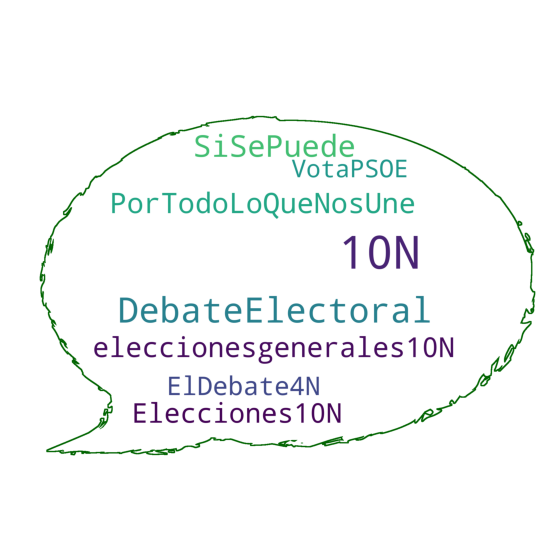

Network 90%


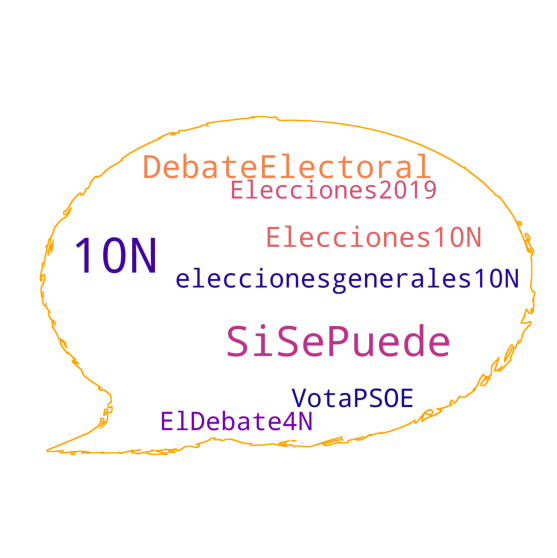

Network 100%


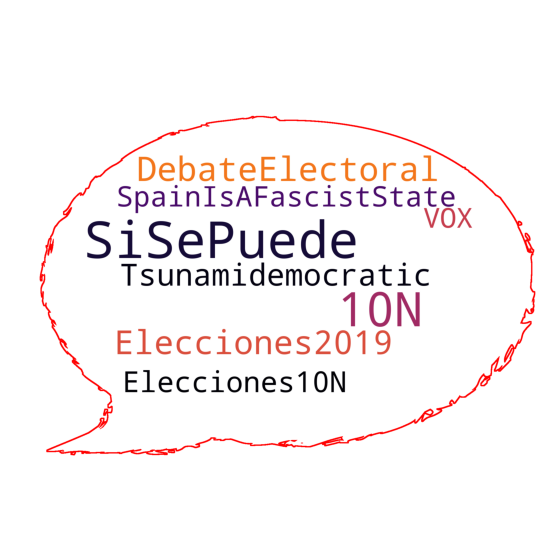

In [30]:
df_stats = df_hashtags

contour_colors = {
    70: 'darkgreen',
    90: 'orange',
    100: 'red',
}

colormaps = {
    70: 'viridis',
    90: 'plasma',
    100: 'inferno'
}

# filter tweets per author's botscore
for percentage in [70, 90, 100]:
    print("Network " + str(percentage) +"%")
    
    df_stats2 = df_stats[df_stats.botscore < percentile[percentage]]
    
    text = ' '.join(df_stats2['hashtag'].astype('str'))
            
    wordcloud2 = WordCloud(
        random_state=1,
        background_color='white',
        contour_color=contour_colors[percentage],
        contour_width=2,
        colormap=colormaps[percentage],
        collocations=False,
        max_words=8,
        mask=mask).generate(text)

    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud2)
    plt.axis("off")
    plt.savefig(f"images/wordcloud-{percentage}%.svg", bbox_inches = "tight", transparent=True)
    plt.show()
    df_stats = df_stats[df_stats.botscore >= percentile[percentage]]

#### Building graph concurrence network per network 70%, 90%, 100%

In [27]:
prs = [70,90]
ps = np.percentile(a=users.botscore, q=prs, interpolation='lower')

percentile = {70: ps[0],
              90: ps[1],
              100: 1.01}

df_concurrence = df_hashtags

# filter tweets per author's botscore
for percentage in [70, 90, 100]:
    print("Network " + str(percentage) +"%")

    dic = {
        'hashtag1' : [],
        'hashtag2' : []
    }
    
    df_situation = df_concurrence[df_concurrence.botscore < percentile[percentage]]

    # group pairs of hashtags concurring on same tweet
    for tweet_id, tweet_id_grp in df_situation[['hashtag','tweet_id']].groupby('tweet_id'):
        if len(tweet_id_grp) > 1:
            #display(tweet_id_grp)
            tweet_id_grp_array = tweet_id_grp.hashtag.array
            for ihast in range(0, len(tweet_id_grp_array),1):
                for jhast in range(ihast+1, len(tweet_id_grp_array),1):
                    dic['hashtag1'].append(tweet_id_grp_array[ihast])
                    dic['hashtag2'].append(tweet_id_grp_array[jhast])

    df_situation = pd.DataFrame.from_dict(dic, orient='columns')
    
    # edges from dataframe
    df_edges = df_situation.groupby(['hashtag1','hashtag2']).size().reset_index().rename(columns={0:'weight'})   # count ocurrences of concurrent hashtag appearance
        
    
    G = nx.from_pandas_edgelist(df=df_edges, source='hashtag1', target='hashtag2', edge_attr='weight', create_using=nx.Graph)
    nx.write_graphml(G, f"graphs/hashtag-networks-{percentage}.graphml")
    
    df_concurrence = df_concurrence[df_concurrence.botscore >= percentile[percentage]]
    
    print("DONE!")

Network 70%
DONE!
Network 90%
DONE!
Network 100%
DONE!


## 2. Virality

#### Getting retweets + tweets, date and botscores

In [31]:
df_retweets['botscore'] = df_retweets.retweet_author.map(users_botscore)
df_tweets['botscore'] = df_tweets.tweet_author.map(users_botscore)
tweet_date = dict(zip(df_tweets.tweet_id, df_tweets.date))

In [32]:
## join each retweet with original tweet's botscore
df_virality = df_retweets.rename(columns={'botscore':'retweet_botscore'}).join(df_tweets[['tweet_id','botscore']].rename(columns={'botscore':'tweet_botscore'}).set_index('tweet_id'), on='tweet_id')
df_virality.dropna(inplace=True)
df_virality['time_to_retweet'] = (df_virality.date-df_virality.tweet_id.map(tweet_date)).apply(lambda d : d.total_seconds()/(3600*24))
df_virality.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5106864 entries, 1 to 7868858
Data columns (total 6 columns):
 #   Column            Dtype         
---  ------            -----         
 0   tweet_id          object        
 1   retweet_author    object        
 2   date              datetime64[ns]
 3   retweet_botscore  float64       
 4   tweet_botscore    float64       
 5   time_to_retweet   float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 272.7+ MB


In [33]:
df_virality.sample(5)

,tweet_id,retweet_author,date,retweet_botscore,tweet_botscore,time_to_retweet
3068623,000001185957450928852995,000000000000000858984690,2019-10-20 23:02:17,0.05,0.00,0.269363
6243712,000001181259579751112709,000000719159230423527424,2019-10-07 21:26:17,0.19,0.52,0.166343
1286312,000001180069519416610817,000000000000000298468622,2019-10-04 18:49:00,0.17,0.10,0.341065
3690866,000001185148824148463616,000000000000004257642292,2019-10-18 14:56:40,0.27,0.00,0.163507
3315000,000001185954443516362757,000000910499470927949825,2019-10-20 19:00:42,0.41,0.08,0.109896


### Retweet cascade metrics

In [34]:
%%time

prs = [70,90]
ps = np.percentile(a=users.botscore, q=prs, interpolation='lower')

percentile = {70: ps[0],
              90: ps[1],
              100: 1.01}

us = {
    70: 'Likely Humans',
    90: 'Likely Semi-Bots',
    100: 'Likely Bots'
}

CPU times: user 20.4 ms, sys: 3 µs, total: 20.4 ms
Wall time: 19.6 ms


#### Iterate over retweets to calculate different metrics...

In [35]:
%%time 

retweets_dic = {
    'tweet_id': [],
    #'tweets_cumulative': [],
    'retweets_cumulative': [],
    'retweeter_position': [],
    'time_to_retweet': [],
    'Retweeter' : [],
    'Tweeter' : [],
    'final_retweeter': []
}

MAX_RETWEETERS = 0

df_tweets_by_botscore_no_cumulative = df_virality
#df_tweets_by_botscore_cumulative = df_virality


# filter tweets per author's botscore
for percentage_tweet in [70, 90, 100]:
    
    tweeters_situation = us[percentage_tweet]
    
    print("- Content generated until " + str(percentage_tweet) +"% of the network")

    
    for tweets_cumulative in [False]:
        
        print("-- MODE : " + str(tweets_cumulative))

                        
        if tweets_cumulative:
            df_tweets_by_botscore = df_tweets_by_botscore_cumulative[df_tweets_by_botscore_cumulative.tweet_botscore < percentile[percentage_tweet]]
        else:
            df_tweets_by_botscore= df_tweets_by_botscore_no_cumulative[df_tweets_by_botscore_no_cumulative.tweet_botscore < percentile[percentage_tweet]]
    
    
        df_retweets_by_botscore_no_cumulative = df_tweets_by_botscore
        df_retweets_by_botscore_cumulative = df_tweets_by_botscore

        #### calculate virality
        for percentage_retweet in [70, 90, 100]:
            print("--- Content retweeted until " + str(percentage_retweet) +"% of the network")


            retweeters_situation = us[percentage_retweet]


            for retweets_cumulative in [False, True]:
                
                print("---- MODE : " + str(retweets_cumulative))

                if retweets_cumulative:
                    df_situation = df_retweets_by_botscore_cumulative[df_retweets_by_botscore_cumulative.retweet_botscore < percentile[percentage_retweet]]
                else:
                    df_situation = df_retweets_by_botscore_no_cumulative[df_retweets_by_botscore_no_cumulative.retweet_botscore < percentile[percentage_retweet]]


                for tweet_id, tweet_id_group in df_situation.groupby('tweet_id'):
                    tweet_id_group = tweet_id_group.sort_values(by='time_to_retweet').reset_index(drop=True)

                    last_index = len(tweet_id_group)-1
                    index = 0
                    for index, value in tweet_id_group.time_to_retweet.iteritems():
                        retweets_dic['tweet_id'].append(tweet_id)
                        retweets_dic['retweets_cumulative'].append(retweets_cumulative)
                        #retweets_dic['tweets_cumulative'].append(tweets_cumulative)
                        retweets_dic['retweeter_position'].append(index)
                        retweets_dic['time_to_retweet'].append(value)
                        retweets_dic['Retweeter'].append(retweeters_situation)
                        retweets_dic['Tweeter'].append(tweeters_situation)
                        if index==last_index:
                            retweets_dic['final_retweeter'].append(True)
                        else:
                            retweets_dic['final_retweeter'].append(False)

                    if index > MAX_RETWEETERS:
                        MAX_RETWEETERS = index

            df_retweets_by_botscore_no_cumulative = df_retweets_by_botscore_no_cumulative[df_retweets_by_botscore_no_cumulative.retweet_botscore >= percentile[percentage_retweet]]
            
    df_tweets_by_botscore_no_cumulative= df_tweets_by_botscore_no_cumulative[df_tweets_by_botscore_no_cumulative.tweet_botscore >= percentile[percentage_tweet]]
    
df_cascades = pd.DataFrame.from_dict(retweets_dic, orient='columns')

- Content generated until 70% of the network
-- MODE : False
--- Content retweeted until 70% of the network
---- MODE : False
---- MODE : True
--- Content retweeted until 90% of the network
---- MODE : False
---- MODE : True
--- Content retweeted until 100% of the network
---- MODE : False
---- MODE : True
- Content generated until 90% of the network
-- MODE : False
--- Content retweeted until 70% of the network
---- MODE : False
---- MODE : True
--- Content retweeted until 90% of the network
---- MODE : False
---- MODE : True
--- Content retweeted until 100% of the network
---- MODE : False
---- MODE : True
- Content generated until 100% of the network
-- MODE : False
--- Content retweeted until 70% of the network
---- MODE : False
---- MODE : True
--- Content retweeted until 90% of the network
---- MODE : False
---- MODE : True
--- Content retweeted until 100% of the network
---- MODE : False
---- MODE : True
CPU times: user 16min 18s, sys: 4.87 s, total: 16min 23s
Wall time: 16min 2

In [36]:
df_cascades['retweeter_position_bin'] = pd.cut(x=df_cascades.retweeter_position, bins=pd.interval_range(start=0,end=max(df_cascades.retweeter_position),freq=50, closed='left'))
df_cascades['retweeter_position_bin_2'] = pd.cut(x=df_cascades.retweeter_position, bins=pd.interval_range(start=0,end=max(df_cascades.retweeter_position),freq=20, closed='left'))
df_cascades.head()

,tweet_id,retweets_cumulative,retweeter_position,time_to_retweet,Retweeter,Tweeter,final_retweeter,retweeter_position_bin,retweeter_position_bin_2
0,000001179908993923391488,False,0,0.077917,Likely Humans,Likely Humans,True,"[0, 50)","[0, 20)"
1,000001179909022046183426,False,0,0.000810,Likely Humans,Likely Humans,False,"[0, 50)","[0, 20)"
2,000001179909022046183426,False,1,0.002338,Likely Humans,Likely Humans,False,"[0, 50)","[0, 20)"
3,000001179909022046183426,False,2,0.005023,Likely Humans,Likely Humans,False,"[0, 50)","[0, 20)"
4,000001179909022046183426,False,3,0.005833,Likely Humans,Likely Humans,False,"[0, 50)","[0, 20)"


## 2.1. Graphic per cascade size

#### By tweet authorship  (CONTENT POINT OF VIEW)

CPU times: user 36.9 s, sys: 7.83 s, total: 44.7 s
Wall time: 30.4 s


<Figure size 576x360 with 0 Axes>

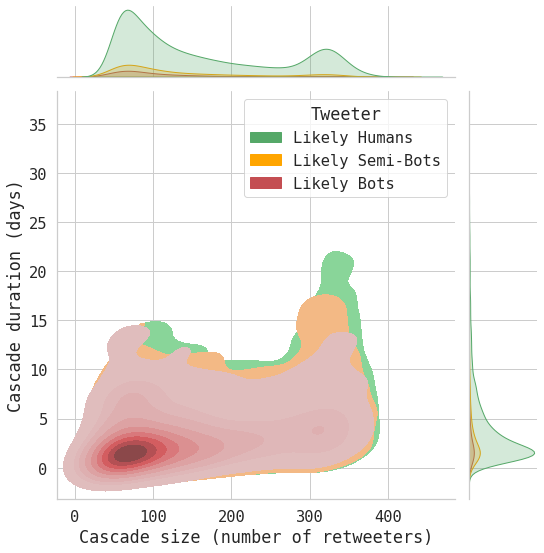

In [103]:
%%time

fig = plt.figure(figsize=(8,5))

FILTERING_CASCADE_SIZE = 50

ax = sns.jointplot(
    data=df_cascades[(df_cascades.retweets_cumulative==True) &
                     (df_cascades.Retweeter=='Likely Bots') &
                     (df_cascades.final_retweeter==True) &
                     (df_cascades.retweeter_position>=FILTERING_CASCADE_SIZE)],
    x='retweeter_position',
    y='time_to_retweet',
    kind='kde',
    fill=True,
    #ylim = (0,600),
    hue='Tweeter',
    common_norm=False,
    levels=10,
    palette={'Likely Humans':'g','Likely Semi-Bots':'orange','Likely Bots':'r'},
    #marginal_kws={"color":"r", "alpha":.2}, shade=True, alpha=.5,
    height=8,
)

ax.set_axis_labels('Cascade size (number of retweeters)','Cascade duration (days)')

#plt.xlim(0,400)
#plt.ylim(0,25)

#ax.legend([],[], frameon=False)


ax.savefig("images/cascades.svg", bbox_inches = "tight")

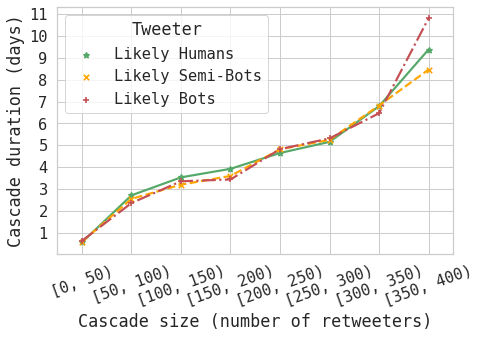

In [128]:
rows = 1
fig, axs = plt.subplots(rows, 1, figsize=(7,5))

#axs.title.set_text('Original tweets generated by ' + us[percent[row]])
ax = sns.pointplot(
    data=df_cascades[(df_cascades.retweets_cumulative==True) & (df_cascades.Retweeter=='Likely Bots') & (df_cascades.final_retweeter==True)],
    x='retweeter_position_bin',
    y='time_to_retweet',
    hue='Tweeter',
    scale=0.8,
    markers=['*','x','+'],
    linestyles=["-", "--", "-."],
    ci=None,
    #dodge=0.1,
    palette={'Likely Humans':'g','Likely Semi-Bots':'orange','Likely Bots':'r'},
    ax=axs,
    legend=False)
    
    
#plt.legend([],[], frameon=False)

ax.set_xlabel('Cascade size (number of retweeters)')#, rotation=180)
ax.set_ylabel('Cascade duration (days)')
        
#plt.xticks(np.arange(0, 400, 10))

plt.yticks(np.arange(1, 12, 1))

#fig.suptitle("Time-to-retweet per retweeter", y=1.01)

ax.grid(True)


plt.xticks(rotation=20)
#plt.yticks(rotation=90)


plt.tight_layout()
plt.savefig("images/cascades-average.svg")
plt.savefig("images/cascades-average.pdf")

#### By retweet authorship (ACTION POINT OF VIEW)

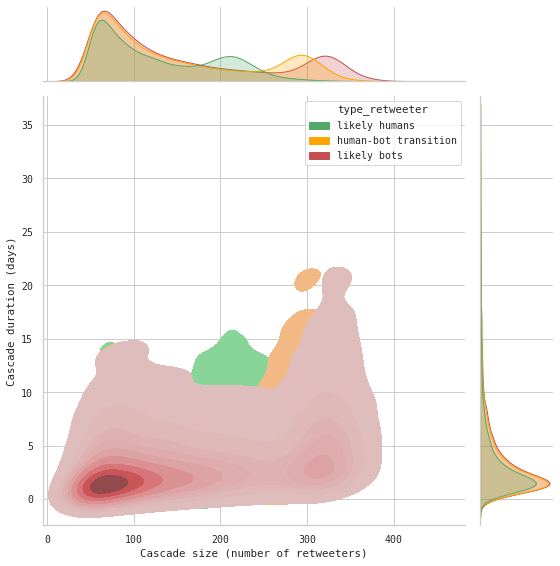

In [36]:
FILTERING_CASCADE_SIZE = 50

ax = sns.jointplot(
    data=df_cascades[(df_cascades.retweets_cumulative==True) & (df_cascades.final_retweeter==True) & (df_cascades.retweeter_position>=FILTERING_CASCADE_SIZE)],
    x='retweeter_position',
    y='time_to_retweet',
    kind='kde',
    fill=True,
    #ylim = (0,600),
    hue='Retweeter',
    common_norm=False,
    levels=10,
    #hue_order=['Likely Bots', 'Likely Semi-Bots', 'Likely Humans'],
    palette={'Likely Humans':'g','Likely Semi-Bots':'orange','Likely Bots':'r'},
    height=8,
    #alpha=0.8
)

ax.set_axis_labels('Cascade size (number of retweeters)','Cascade duration (days)')
ax.savefig("images/cascades-by-retweeter.svg", bbox_inches = "tight")

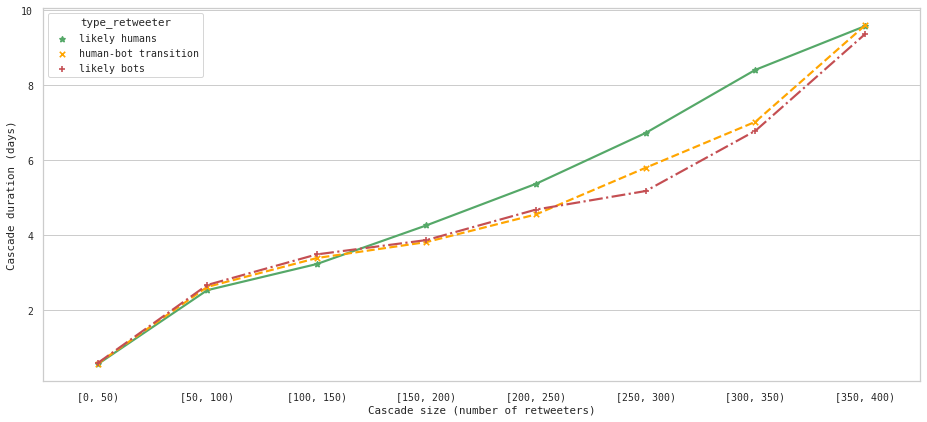

In [37]:
rows = 1
fig, axs = plt.subplots(rows, 1, figsize=(13,6), sharex=True, sharey=True)

#axs.title.set_text('Original tweets generated by ' + us[percent[row]])
ax = sns.pointplot(
    data=df_cascades[(df_cascades.retweets_cumulative==True) & (df_cascades.final_retweeter==True)],
    x='retweeter_position_bin',
    y='time_to_retweet',
    hue='Retweeter',
    scale=0.8,
    markers=['*','x','+'],
    linestyles=["-", "--", "-."],
    ci=None,
    #dodge=0.1,
    palette={'Likely Humans':'g','Likely Semi-Bots':'orange','Likely Bots':'r'},
    ax=axs)
    

ax.set_xlabel('Cascade size (number of retweeters)')
ax.set_ylabel('Cascade duration (days)')
        
#plt.xticks(np.arange(0, 400, 10))
#plt.yticks(np.arange(0, 200, 24))
#fig.suptitle("Time-to-retweet per retweeter", y=1.01)
plt.tight_layout()
plt.savefig("images/cascades-by-retweeter-2.svg")

## 2.2. Formation of cascades per ith-retweeter

likely humans
human-bot transition
likely bots


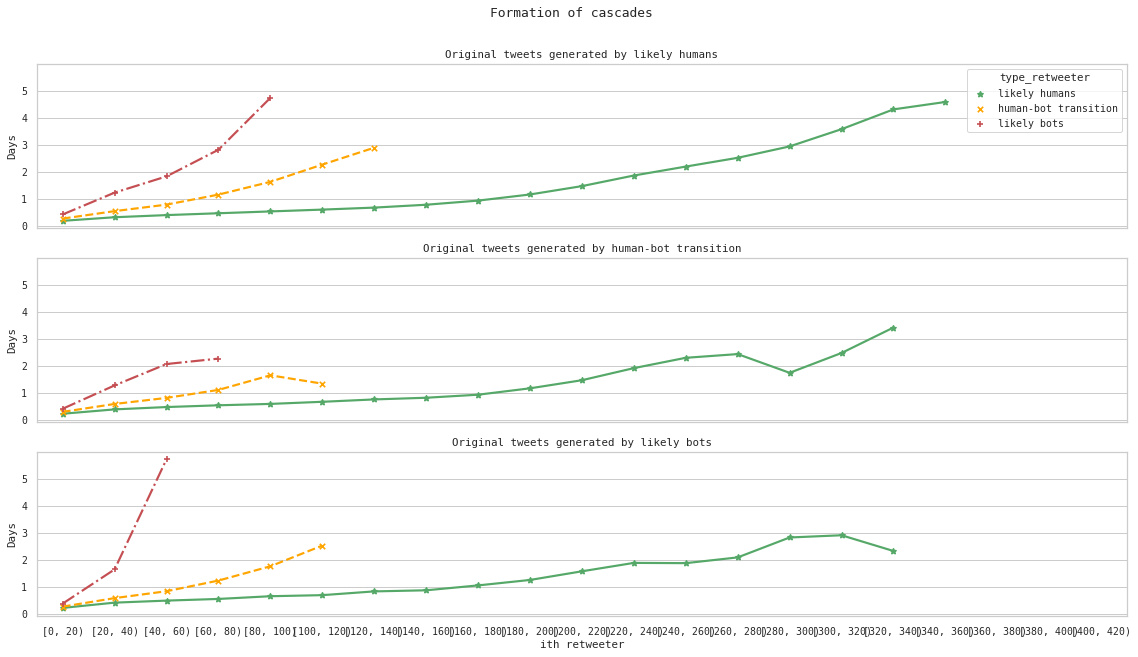

In [38]:
rows = 3
fig, axs = plt.subplots(rows, 1, figsize=(16,9), sharex=True, sharey=True)
row = 0
percent = [70, 90, 100]
ax=None
for tweeters in us.values():
    print(tweeters)
    ax = axs[row]
    ax.title.set_text('Original tweets generated by ' + us[percent[row]])
    ax = sns.pointplot(
        data=df_cascades[(df_cascades.Retweeter==tweeters) & (df_cascades.retweets_cumulative==False)],
        x='retweeter_position_bin_2',
        y='time_to_retweet',
        hue='Retweeter',
        scale=0.8,
        markers=['*','x','+'],
        linestyles=["-", "--", "-."],
        ci=None,
        palette={
            'Likely Humans':'g',
            'Likely Semi-Bots':'orange',
            'Likely Bots':'r'},
        orientation=u'horizontal', 
        ax=ax)
    
    #ax.invert_xaxis()
    
    if row > 0:
        ax.get_legend().remove()
    
    if row==2:
        ax.set_xlabel('ith retweeter')
    else: 
        ax.set_xlabel('')
    
    ax.set_ylabel('Days')

        
    row=row+1
    #custom_ylim = (0,80)
    #plt.setp(ax, ylim=custom_ylim)

#plt.xticks(np.arange(0, 400, 10))
#plt.yticks(np.arange(0, 3, 1))
fig.suptitle("Formation of cascades", y=1.01)
plt.tight_layout()
plt.savefig("images/formation-cascades.svg")

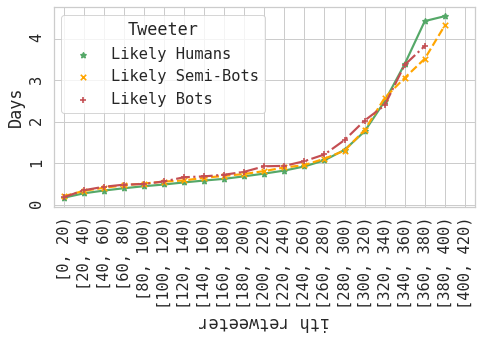

In [129]:
fig, axs = plt.subplots(1, 1, figsize=(7,5))

d = df_cascades[(df_cascades.retweets_cumulative==True) &
                (df_cascades.Retweeter=='Likely Bots') &
                (df_cascades.retweeter_position_bin_2.apply(lambda l : l.right)<=400)]

ax = axs
ax = sns.pointplot(
    data=d,
    x='retweeter_position_bin_2',
    y='time_to_retweet',
    hue='Tweeter',
    scale=0.8,
    markers=['*','x','+'],
    linestyles=["-", "--", "-."],
    ci=None,
    palette={
        'Likely Humans':'g',
        'Likely Semi-Bots':'orange',
        'Likely Bots':'r'},
    #orientation=u'horizontal', 
    ax=ax)


ax.set_xlabel('ith retweeter', rotation=180)
ax.set_ylabel('Days')

#plt.xlim(left=0, right=10000)

#plt.xticks(np.arange(0, 400, 10))
#plt.yticks(np.arange(0, 3, 1))

plt.xticks(rotation=90)
plt.yticks(rotation=90)
ax.grid(True)

#plt.legend([],[], frameon=False)

plt.tight_layout()
plt.savefig("images/formation-cascades.svg")

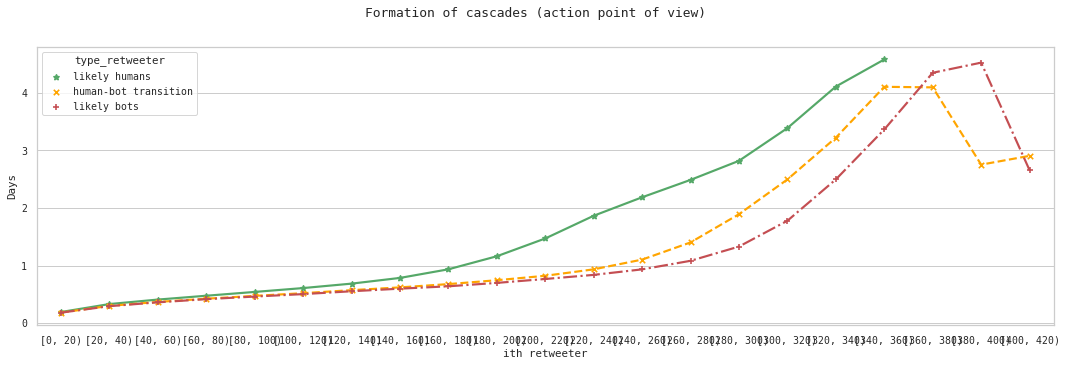

In [40]:
fig, axs = plt.subplots(1, 1, figsize=(15,5), sharex=True, sharey=True)

ax = axs
ax = sns.pointplot(
    data=df_cascades[(df_cascades.retweets_cumulative==True)],
    x='retweeter_position_bin_2',
    y='time_to_retweet',
    hue='Retweeter',
    scale=0.8,
    markers=['*','x','+'],
    linestyles=["-", "--", "-."],
    ci=None,
    palette={
        'Likely Humans':'g',
        'Likely Semi-Bots':'orange',
        'Likely Bots':'r'},
    orientation=u'horizontal', 
    ax=ax)

#ax.invert_xaxis()

ax.set_xlabel('ith retweeter')
ax.set_ylabel('Days')

#custom_ylim = (0,80)
#plt.setp(ax, ylim=custom_ylim)

#plt.xticks(np.arange(0, 400, 10))
#plt.yticks(np.arange(0, 3, 1))
fig.suptitle("Formation of cascades (action point of view)", y=1.01)
plt.tight_layout()
plt.savefig("images/formation-cascades-by-retweeter.svg")